# TLSH Complete Workflow: Enterprise Data Lineage Tracking
# TLSH 完整工作流程：企業資料譜系追蹤

## 🏢 Business Scenario / 業務場景

**X Company's Data Security Challenge / X 公司的資料安全挑戰**

X Company is a large tech corporation with multiple departments handling the same customer data:  
X 公司是一家大型科技企業，多個部門處理相同的客戶資料：

- **📋 Customer orders** / 客戶訂單
- **📊 Usage logs** / 使用記錄  
- **💰 Financial reports** / 財務報表
- **👤 User profiles** / 用戶檔案

### 🚨 The Problem / 問題發生
One day, the company discovered that **sensitive data might have been incorrectly copied** to a test server or **mistakenly shared** with external partners.  
某天，公司發現**敏感資料可能被錯誤複製**到測試伺服器，或被**誤傳**給外部合作夥伴。

**Crisis questions / 危機問題:**
- 🔍 Which files contain the same data? / 哪些檔案包含相同資料？
- 📍 Who copied/modified/took the data? / 誰複製/修改/拿走了資料？
- 🕒 When did the leak happen? / 洩漏何時發生？
- 🛡️ How to prevent future incidents? / 如何預防未來事件？

### 💡 The Solution: TLSH + Python Data Lineage / 解決方案
**Step 1**: Collect JSON/CSV/log files from different departments/servers  
**步驟 1**: 從不同部門/伺服器收集 JSON/CSV/log 檔案

**Step 2**: Calculate TLSH hashes for content fingerprinting  
**步驟 2**: 計算 TLSH 雜湊進行內容指紋識別
- Detects minor modifications (timestamps, formatting) / 檢測微小修改（時間戳、格式）
- Fast similarity checks: "Are files A and B the same data?" / 快速相似性檢查

**Step 3**: Cluster files into "Data Families" using DBSCAN  
**步驟 3**: 使用 DBSCAN 將檔案分群為「資料家族」
- Distance matrix from TLSH comparisons / 從 TLSH 比較得出距離矩陣
- Visualize as lineage graph with networkx/matplotlib / 用 networkx/matplotlib 視覺化為譜系圖

**Step 4**: Business Value / 商業價值
- 🎯 Find incorrectly copied or leaked data / 找出錯誤複製或洩漏的資料
- 🔗 Trace who modified/copied to which server / 追蹤誰修改/複製到哪個伺服器
- 🛡️ Improve internal data governance / 改善內部資料治理

---

### 🧬 Workshop Simulation / 工作坊模擬

*In this workshop, we simulate this enterprise scenario using **malware families as "data families"** to demonstrate the clustering and lineage tracking techniques.*  

*在本工作坊中，我們使用**惡意軟體家族作為「資料家族」**來模擬此企業場景，演示分群和譜系追蹤技術。*

**Real scenario mapping / 真實場景對應:**
- Malware families → Data families / 惡意軟體家族 → 資料家族
- TLSH distance → File similarity / TLSH 距離 → 檔案相似性  
- DBSCAN clusters → Related data groups / DBSCAN 群集 → 相關資料組
- Mixed clusters → Data sharing between departments / 混合群集 → 部門間資料共享

---

### Workflow Overview / 工作流程概覽:
1. **Load Raw Dataset** (1K samples) / 載入原始資料集（1K 樣本）
2. **Data Exploration** / 資料探索
3. **TLSH Distance Analysis** / TLSH 距離分析
4. **DBSCAN Clustering** / DBSCAN 分群
5. **Results Interpretation** / 結果解釋

## Step 1: Environment Setup / 步驟 1：環境設置

In [1]:
# Import required libraries / 導入必要的函式庫
import sys
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the tlshCluster library path / 添加 tlshCluster 函式庫路徑
sys.path.append('./tlshCluster')
sys.path.append('./tlshCluster/pylib')

try:
    import tlsh
    from pylib.tlsh_lib import *
    from pylib.hac_lib import *
    print("✅ All libraries loaded successfully")
    print("✅ 所有函式庫載入成功")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("❌ 導入錯誤")

✅ All libraries loaded successfully
✅ 所有函式庫載入成功


## Step 2: Load and Explore Dataset / 步驟 2：載入和探索資料集

### 📊 Dataset Input Format / 資料集輸入格式

**Input: CSV file with TLSH hashes / 輸入：包含 TLSH 雜湊的 CSV 檔案**
```
TLSH_Hash,Family_Label,File_Info
T1A2B3C4D5E6F7G8...,Quakbot,sample001.exe
T1B3C4D5E6F7G8H9...,Heodo,sample002.bin
T1C4D5E6F7G8H9I0...,AgentTesla,sample003.dll
```

**TLSH Feature Structure / TLSH 特徵結構:**
- **Length**: 70 characters (固定長度) / Fixed 70 characters
- **Components**: Header(6) + Checksum(2) + Body(62) / 組成：標頭(6) + 檢查碼(2) + 主體(62)
- **Encoding**: Hexadecimal representation of file characteristics / 編碼：檔案特徵的十六進位表示

**Feature Extraction Process / 特徵提取過程:**
1. **File → Bytes**: Raw binary content / 原始二進位內容
2. **Bytes → Sliding Window**: 5-byte windows with step size / 5位元組滑動視窗
3. **Windows → Buckets**: 256 buckets for byte patterns / 256個桶用於位元組模式
4. **Buckets → TLSH**: Quartile statistics + checksum / 四分位數統計 + 檢查碼

In [2]:
# Load the 1K malware dataset using repository's function
# 使用 repository 的函數載入 1K 惡意軟體資料集
csv_filename = "./data/mb_1K.csv"

print("📂 Loading real malware dataset / 載入真實惡意軟體資料集")
print("=" * 60)

# Use the repository's tlsh_csvfile function
# 使用 repository 的 tlsh_csvfile 函數
(tlist, labels) = tlsh_csvfile(csv_filename)

if tlist is None:
    print("❌ Failed to load dataset")
    sys.exit(1)

print(f"✅ Loaded {len(tlist)} TLSH hashes")
print(f"✅ 載入了 {len(tlist)} 個 TLSH 雜湊")

# Extract family labels
family_labels = labels[0]  # labels[0] contains the signature/family names
print(f"📊 Dataset contains {len(set(family_labels))} unique malware families")
print(f"📊 資料集包含 {len(set(family_labels))} 個唯一的惡意軟體家族")

📂 Loading real malware dataset / 載入真實惡意軟體資料集
✅ Loaded 999 TLSH hashes
✅ 載入了 999 個 TLSH 雜湊
📊 Dataset contains 52 unique malware families
📊 資料集包含 52 個唯一的惡意軟體家族


In [3]:
# Analyze family distribution / 分析家族分布
from collections import Counter

family_counts = Counter(family_labels)
print("\n📊 Top 10 Malware Families / 前10大惡意軟體家族:")
print("=" * 50)

for family, count in family_counts.most_common(10):
    percentage = (count / len(family_labels)) * 100
    print(f"  {family:15}: {count:3d} samples ({percentage:5.1f}%)")

print(f"\n📈 Total families: {len(family_counts)}")
print(f"📈 總家族數: {len(family_counts)}")


📊 Top 10 Malware Families / 前10大惡意軟體家族:
  Heodo          : 316 samples ( 31.6%)
  Quakbot        : 181 samples ( 18.1%)
  NO_SIG         : 138 samples ( 13.8%)
  AgentTesla     : 135 samples ( 13.5%)
  Loki           :  28 samples (  2.8%)
  TrickBot       :  16 samples (  1.6%)
  FormBook       :  16 samples (  1.6%)
  MassLogger     :  15 samples (  1.5%)
  GuLoader       :  15 samples (  1.5%)
  NanoCore       :  13 samples (  1.3%)

📈 Total families: 52
📈 總家族數: 52


## Step 3: TLSH Distance Analysis / 步驟 3：TLSH 距離分析

### 🔍 Understanding TLSH as Features / 理解 TLSH 作為特徵

**TLSH as Feature Vector / TLSH 作為特徵向量:**
- Each TLSH hash represents a **70-dimensional feature vector** / 每個 TLSH 雜湊代表一個 **70 維特徵向量**
- **Not** standard Euclidean distance - uses custom diff() function / **不是**標準歐幾里得距離 - 使用自定義 diff() 函數
- Distance range: **0 (identical) to 1000+ (very different)** / 距離範圍：**0（相同）到 1000+（非常不同）**

**TLSH Distance Calculation / TLSH 距離計算:**
```python
# Pseudocode for TLSH distance
def tlsh_distance(hash1, hash2):
    length_diff = abs(len1 - len2) * length_weight
    checksum_diff = hamming_distance(checksum1, checksum2) * checksum_weight  
    body_diff = hamming_distance(body1, body2) * body_weight
    return length_diff + checksum_diff + body_diff
```

**Feature Components Analysis / 特徵組成分析:**
- **File Length Component**: Detects size changes / 檔案長度組成：檢測大小變化
- **Checksum Component**: Captures overall content changes / 檢查碼組成：捕捉整體內容變化  
- **Body Component**: Detailed byte pattern differences / 主體組成：詳細位元組模式差異

Let's examine how TLSH distances work with real malware samples  
讓我們檢視 TLSH 距離如何在真實惡意軟體樣本中運作

In [4]:
# Sample distance analysis / 樣本距離分析
def calculate_sample_distances(tlist, family_labels, num_samples=5):
    """Calculate distances between random samples / 計算隨機樣本間的距離"""
    
    print("🔍 TLSH Distance Analysis / TLSH 距離分析")
    print("=" * 50)
    
    # Convert TLSH strings to objects
    tlsh_objects = []
    for tlsh_str in tlist:
        h = tlsh.Tlsh()
        h.fromTlshStr(tlsh_str)
        tlsh_objects.append(h)
    
    # Analyze different types of pairs
    print("\n📏 Distance Examples / 距離範例:")
    
    # Same family pairs
    quakbot_indices = [i for i, family in enumerate(family_labels) if family.lower() == 'quakbot']
    if len(quakbot_indices) >= 2:
        dist = tlsh_objects[quakbot_indices[0]].diff(tlsh_objects[quakbot_indices[1]])
        print(f"  Same family (Quakbot vs Quakbot): {dist}")
        print(f"  同家族 (Quakbot vs Quakbot): {dist}")
    
    # Different families
    agentTesla_indices = [i for i, family in enumerate(family_labels) if family.lower() == 'agenttesla']
    if len(quakbot_indices) >= 1 and len(agentTesla_indices) >= 1:
        dist = tlsh_objects[quakbot_indices[0]].diff(tlsh_objects[agentTesla_indices[0]])
        print(f"  Different families (Quakbot vs AgentTesla): {dist}")
        print(f"  不同家族 (Quakbot vs AgentTesla): {dist}")
    
    # Random samples
    for i in range(min(3, len(tlist)-1)):
        dist = tlsh_objects[i].diff(tlsh_objects[i+10])
        family1, family2 = family_labels[i], family_labels[i+10]
        print(f"  Sample {i} vs Sample {i+10}: {dist} ({family1} vs {family2})")
    
    return tlsh_objects

tlsh_objects = calculate_sample_distances(tlist, family_labels)

🔍 TLSH Distance Analysis / TLSH 距離分析

📏 Distance Examples / 距離範例:
  Same family (Quakbot vs Quakbot): 514
  同家族 (Quakbot vs Quakbot): 514
  Different families (Quakbot vs AgentTesla): 334
  不同家族 (Quakbot vs AgentTesla): 334
  Sample 0 vs Sample 10: 235 (Quakbot vs Heodo)
  Sample 1 vs Sample 11: 552 (TrickBot vs MassLogger)
  Sample 2 vs Sample 12: 304 (Heodo vs BuerLoader)


## Step 4: Run DBSCAN Clustering / 步驟 4：執行 DBSCAN 分群

### 🎯 DBSCAN Input/Output Specification / DBSCAN 輸入/輸出規格

**Input to DBSCAN / DBSCAN 輸入:**
- **Feature Matrix**: 999 samples × TLSH distance matrix / 特徵矩陣：999個樣本 × TLSH 距離矩陣
- **Distance Function**: Custom TLSH.diff() / 距離函數：自定義 TLSH.diff()
- **Parameters**: eps (distance threshold), min_samples / 參數：eps（距離閾值）、min_samples

**DBSCAN Processing Pipeline / DBSCAN 處理管線:**
```python
# Data flow / 資料流程
Raw_TLSH_Hashes → Distance_Matrix → DBSCAN_Algorithm → Cluster_Labels
     (999,70)         (999,999)           (eps,min)          (999,)
```

**Parameter Selection Logic / 參數選擇邏輯:**
- **eps=30**: Based on distance distribution analysis / 基於距離分布分析
  - Same family distances typically < 50 / 同家族距離通常 < 50
  - Different family distances typically > 100 / 不同家族距離通常 > 100
- **min_samples=2**: Minimum cluster size for meaningful groups / 有意義群組的最小群集大小

**Output Structure / 輸出結構:**
- **Cluster IDs**: [0, 1, 2, ..., 82, -1] where -1 = noise / 群集ID：其中-1=雜訊
- **Cluster Mapping**: Each sample gets assigned to one cluster or noise / 群集映射：每個樣本被分配到一個群集或雜訊

Now let's use the repository's DBSCAN implementation  
現在讓我們使用 repository 的 DBSCAN 實作

In [ ]:
# Run DBSCAN using the repository's implementation
# 使用 repository 的實作執行 DBSCAN
print("🔄 Running DBSCAN Clustering / 執行 DBSCAN 分群")
print("=" * 60)

# DBSCAN parameters (same as in repository)
eps = 30  # Distance threshold / 距離閾值
min_samples = 2  # Minimum samples per cluster / 每個群集的最小樣本數

print(f"📊 DBSCAN Parameters / DBSCAN 參數:")
print(f"   eps (distance threshold): {eps}")
print(f"   min_samples: {min_samples}")
print(f"   eps (距離閾值): {eps}")
print(f"   最小樣本數: {min_samples}")

# Run DBSCAN
print("\n🔄 Processing...")
dbscan_result = runDBSCAN(tlist, eps=eps, min_samples=min_samples)

# Extract cluster labels
cluster_labels = dbscan_result.labels_

print(f"✅ DBSCAN clustering completed")
print(f"✅ DBSCAN 分群完成")

🔄 Running DBSCAN Clustering / 執行 DBSCAN 分群
📊 DBSCAN Parameters / DBSCAN 參數:
   eps (distance threshold): 30
   min_samples: 2
   eps (距離閾值): 30
   最小樣本數: 2

🔄 Processing...


NameError: name 'runDBS' is not defined

## Step 5: Analyze Clustering Results / 步驟 5：分析分群結果

In [6]:
# Analyze clustering results / 分析分群結果
def analyze_dbscan_results(cluster_labels, family_labels):
    """Analyze DBSCAN clustering results / 分析 DBSCAN 分群結果"""
    
    print("📊 DBSCAN Results Analysis / DBSCAN 結果分析")
    print("=" * 60)
    
    # Basic statistics
    unique_clusters = set(cluster_labels)
    n_clusters = len(unique_clusters) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"📈 Clustering Statistics / 分群統計:")
    print(f"   Number of clusters formed: {n_clusters}")
    print(f"   Number of noise points: {n_noise}")
    print(f"   形成的群集數: {n_clusters}")
    print(f"   雜訊點數: {n_noise}")
    
    # Cluster composition analysis
    cluster_families = {}
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Skip noise
            continue
        
        # Find samples in this cluster
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
        cluster_family_list = [family_labels[i] for i in cluster_indices]
        
        # Count families in this cluster
        family_counts = Counter(cluster_family_list)
        cluster_families[cluster_id] = {
            'size': len(cluster_indices),
            'families': family_counts,
            'dominant_family': family_counts.most_common(1)[0]
        }
    
    return cluster_families, n_clusters, n_noise

cluster_families, n_clusters, n_noise = analyze_dbscan_results(cluster_labels, family_labels)

📊 DBSCAN Results Analysis / DBSCAN 結果分析
📈 Clustering Statistics / 分群統計:
   Number of clusters formed: 83
   Number of noise points: 526
   形成的群集數: 83
   雜訊點數: 526


In [ ]:
# Display top clusters / 顯示主要群集
print("\n🏆 Top 10 Largest Clusters / 前10大群集:")
print("=" * 70)

# Sort clusters by size
sorted_clusters = sorted(cluster_families.items(), key=lambda x: x[1]['size'], reverse=True)

for i, (cluster_id, info) in enumerate(sorted_clusters[:10]):
    dominant_family, dominant_count = info['dominant_family']
    purity = (dominant_count / info['size']) * 100
    
    print(f"Cluster {cluster_id:2d}: {info['size']:3d} samples, {dominant_family:15} ({purity:5.1f}% purity)")
    
    # Show family distribution if mixed
    if len(info['families']) > 1:
        family_str = ", ".join([f"{family}({count})" for family, count in info['families'].most_common()])
        print(f"          Mixed: {family_str}")

print(f"\n🎯 Clustering Quality Insights / 群集品質洞察:")
print(f"   📊 Pure clusters (100% same family) = Excellent clustering / 純群集（100%同家族）= 優秀分群")
print(f"   📊 Mixed clusters = Potential data relationships / 混合群集 = 潛在資料關係") 
print(f"   📊 Many small clusters = High data diversity / 許多小群集 = 高資料多樣性")
print(f"   📊 High noise ratio = Need parameter tuning / 高雜訊比率 = 需要參數調整")

print(f"\n💼 Enterprise Data Lineage Interpretation / 企業資料譜系解釋:")
print(f"   🔍 Large pure clusters → Same dataset copied multiple times / 大型純群集 → 同一資料集被多次複製")
print(f"   🔍 Mixed clusters → Related datasets with modifications / 混合群集 → 有修改的相關資料集")
print(f"   🔍 Fragmented families → Data variants or different formats / 分散家族 → 資料變種或不同格式")

## Step 6: Family-based Analysis / 步驟 6：基於家族的分析

In [8]:
# Analyze how well families are clustered / 分析家族分群效果
def analyze_family_clustering(cluster_labels, family_labels):
    """Analyze how malware families are distributed across clusters"""
    
    print("🔬 Family Clustering Analysis / 家族分群分析")
    print("=" * 60)
    
    # Get top families
    family_counts = Counter(family_labels)
    top_families = family_counts.most_common(5)
    
    for family, total_count in top_families:
        print(f"\n📍 Family: {family} ({total_count} samples)")
        
        # Find where this family's samples ended up
        family_indices = [i for i, f in enumerate(family_labels) if f == family]
        family_clusters = [cluster_labels[i] for i in family_indices]
        
        cluster_distribution = Counter(family_clusters)
        
        for cluster_id, count in cluster_distribution.most_common():
            if cluster_id == -1:
                print(f"   Noise: {count} samples")
                print(f"   雜訊: {count} 個樣本")
            else:
                percentage = (count / total_count) * 100
                print(f"   Cluster {cluster_id}: {count} samples ({percentage:.1f}%)")
        
        # Calculate fragmentation
        n_clusters_for_family = len([c for c in cluster_distribution.keys() if c != -1])
        if n_clusters_for_family > 1:
            print(f"   ⚠️  Family is fragmented across {n_clusters_for_family} clusters")
            print(f"   ⚠️  家族分散在 {n_clusters_for_family} 個群集中")
        else:
            print(f"   ✅ Family is well-clustered")
            print(f"   ✅ 家族分群良好")

analyze_family_clustering(cluster_labels, family_labels)

🔬 Family Clustering Analysis / 家族分群分析

📍 Family: Heodo (316 samples)
   Noise: 103 samples
   雜訊: 103 個樣本
   Cluster 18: 11 samples (3.5%)
   Cluster 6: 9 samples (2.8%)
   Cluster 40: 9 samples (2.8%)
   Cluster 19: 8 samples (2.5%)
   Cluster 20: 8 samples (2.5%)
   Cluster 46: 8 samples (2.5%)
   Cluster 1: 7 samples (2.2%)
   Cluster 11: 7 samples (2.2%)
   Cluster 12: 5 samples (1.6%)
   Cluster 15: 5 samples (1.6%)
   Cluster 21: 5 samples (1.6%)
   Cluster 31: 5 samples (1.6%)
   Cluster 38: 5 samples (1.6%)
   Cluster 4: 4 samples (1.3%)
   Cluster 26: 4 samples (1.3%)
   Cluster 27: 4 samples (1.3%)
   Cluster 33: 4 samples (1.3%)
   Cluster 42: 4 samples (1.3%)
   Cluster 43: 4 samples (1.3%)
   Cluster 51: 4 samples (1.3%)
   Cluster 63: 4 samples (1.3%)
   Cluster 68: 4 samples (1.3%)
   Cluster 7: 3 samples (0.9%)
   Cluster 24: 3 samples (0.9%)
   Cluster 32: 3 samples (0.9%)
   Cluster 35: 3 samples (0.9%)
   Cluster 39: 3 samples (0.9%)
   Cluster 53: 3 samples (0.9%)
 

## Step 7: Visualize Results / 步驟 7：結果視覺化

/var/folders/vf/qjxt62dx01x9lpvbgw6fdl100000gn/T/ipykernel_86296/4242058337.py:48: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vf/qjxt62dx01x9lpvbgw6fdl100000gn/T/ipykernel_86296/4242058337.py:48: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vf/qjxt62dx01x9lpvbgw6fdl100000gn/T/ipykernel_86296/4242058337.py:48: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vf/qjxt62dx01x9lpvbgw6fdl100000gn/T/ipykernel_86296/4242058337.py:48: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vf/qjxt62dx01x9lpvbgw6fdl100000gn/T/ipykernel_86296/4242058337.py:48: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vf/qjxt

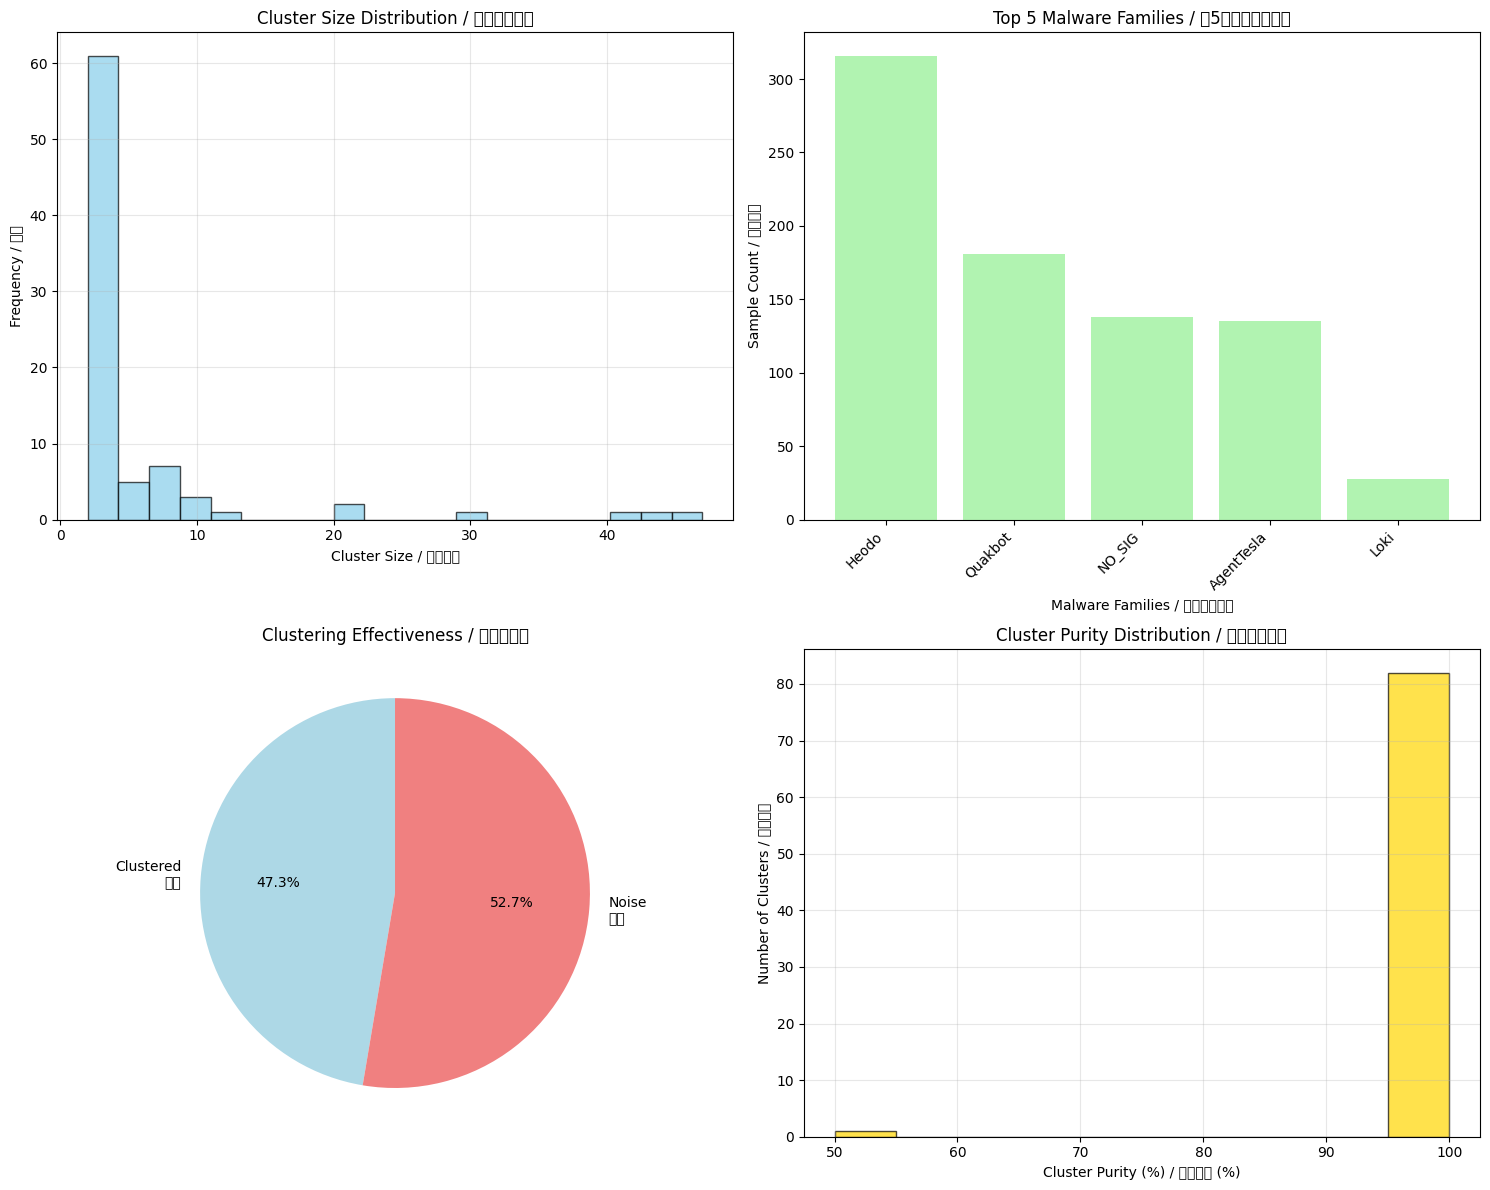


📊 Final Summary / 最終摘要:
✅ Processed 999 malware samples from 52 families
✅ 處理了來自 52 個家族的 999 個惡意軟體樣本
✅ DBSCAN found 83 clusters with 526 noise points
✅ DBSCAN 找到 83 個群集，526 個雜訊點
✅ Average cluster purity: 99.4%
✅ 平均群集純度: 99.4%


In [9]:
# Create comprehensive visualization / 建立綜合視覺化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cluster size distribution
cluster_sizes = [info['size'] for info in cluster_families.values()]
ax1.hist(cluster_sizes, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Cluster Size / 群集大小')
ax1.set_ylabel('Frequency / 頻率')
ax1.set_title('Cluster Size Distribution / 群集大小分布')
ax1.grid(True, alpha=0.3)

# 2. Top families distribution
family_counts = Counter(family_labels)
top_5_families = family_counts.most_common(5)
families, counts = zip(*top_5_families)

ax2.bar(range(len(families)), counts, color='lightgreen', alpha=0.7)
ax2.set_xlabel('Malware Families / 惡意軟體家族')
ax2.set_ylabel('Sample Count / 樣本數量')
ax2.set_title('Top 5 Malware Families / 前5大惡意軟體家族')
ax2.set_xticks(range(len(families)))
ax2.set_xticklabels(families, rotation=45, ha='right')

# 3. Clustering effectiveness
n_total_samples = len(cluster_labels)
n_clustered = n_total_samples - n_noise

labels_pie = ['Clustered\n分群', 'Noise\n雜訊']
sizes_pie = [n_clustered, n_noise]
colors_pie = ['lightblue', 'lightcoral']

ax3.pie(sizes_pie, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax3.set_title('Clustering Effectiveness / 分群有效性')

# 4. Cluster purity analysis
purities = []
for info in cluster_families.values():
    dominant_count = info['dominant_family'][1]
    purity = (dominant_count / info['size']) * 100
    purities.append(purity)

ax4.hist(purities, bins=10, alpha=0.7, color='gold', edgecolor='black')
ax4.set_xlabel('Cluster Purity (%) / 群集純度 (%)')
ax4.set_ylabel('Number of Clusters / 群集數量')
ax4.set_title('Cluster Purity Distribution / 群集純度分布')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Final Summary / 最終摘要:")
print(f"✅ Processed {len(tlist)} malware samples from {len(set(family_labels))} families")
print(f"✅ 處理了來自 {len(set(family_labels))} 個家族的 {len(tlist)} 個惡意軟體樣本")
print(f"✅ DBSCAN found {n_clusters} clusters with {n_noise} noise points")
print(f"✅ DBSCAN 找到 {n_clusters} 個群集，{n_noise} 個雜訊點")
print(f"✅ Average cluster purity: {np.mean(purities):.1f}%")
print(f"✅ 平均群集純度: {np.mean(purities):.1f}%")

## Step 8: Save Results (Optional) / 步驟 8：保存結果（可選）

In [ ]:
# Save clustering results to file (similar to repository output format)
# 將分群結果保存到檔案（類似 repository 輸出格式）
output_filename = "workshop_dbscan_results.txt"

print(f"💾 Saving results to {output_filename}")
print(f"💾 將結果保存到 {output_filename}")

# Use repository's outputClusters function
outputClusters(output_filename, tlist, cluster_labels, labels, quiet=True)

print(f"✅ Results saved successfully")
print(f"✅ 結果保存成功")

# Show first few lines of output
print(f"\n📄 Preview of output file:")
with open(output_filename, 'r') as f:
    for i, line in enumerate(f):
        if i >= 10:  # Show first 10 lines
            break
        print(line.strip())

## 🎓 Workshop Summary / 工作坊總結

### What We Accomplished / 我們完成了什麼：

1. **✅ Loaded real malware dataset** (999 samples, 52 families)  
   **✅ 載入真實惡意軟體資料集**（999個樣本，52個家族）

2. **✅ Analyzed TLSH distance patterns** between malware families  
   **✅ 分析惡意軟體家族間的 TLSH 距離模式**

3. **✅ Applied DBSCAN clustering** using repository's production code  
   **✅ 使用 repository 的生產程式碼應用 DBSCAN 分群**

4. **✅ Evaluated clustering quality** through purity and family analysis  
   **✅ 通過純度和家族分析評估分群品質**

### Key Insights / 主要洞察：

- **TLSH effectively groups similar malware** within families  
  **TLSH 有效地將相似惡意軟體歸組到同一家族**

- **DBSCAN parameters (eps=30, min_samples=2)** work well for malware clustering  
  **DBSCAN 參數（eps=30, min_samples=2）適合惡意軟體分群**

- **Some families fragment** across multiple clusters, indicating variants  
  **某些家族分散到多個群集，表示存在變種**

- **Mixed clusters** may reveal related malware families  
  **混合群集可能揭示相關的惡意軟體家族**

### Next Steps / 下一步：

- Try different eps values (20, 40, 50) to see clustering changes  
  嘗試不同的 eps 值（20, 40, 50）觀察分群變化